<h2>Using SAS DLPy to Perform Sine Curve Time Series Forecasting</h2>


The following example uses SAS DLPy to perform time series forecasting using an LSTM-RNN model. 

The example begins by configuring the computing environment by importing various required libraries and Python utilities. Next, data stores are defined and sine curve data is generated. CAS is started, then the time series data is loaded, processed, and partitioned.  Use SAS DLPy create a model and specify a LSTM-RNN model network. 

The following code includes two examples of training the LSTM-RNN model. The first example uses the `model.fit()` function to train `model1`. The second example uses the `model.train()` function to train `model1`. The `model.train()` example code uses some option settings that are not available using `model.fit()`.

Plots are generated to visualize the performance of each of the trained time series forecasting models.

The trained model is used to score partitioned test data. A plot is generated to simultaneously display both the historical (train and validation) model data (in blue) as well as the forecasted (score predictions) data (in red). 


<h3>Configure Environment: Import Python, SWAT, and DLPy Libraries</h3>


Begin by configuring the computing environment for the time series forecasting task. Load required libraries: import `NumPy` as `np`, `pandas` as `pd`, and import the `pyplot` module from `matplotlib ` as `plt`. Load the SWAT data handler as `dmh`, then import the `SAS SWAT` package. 

SWAT is a Python interface to SAS CAS. For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html. 
 
Import DLPy and then import DLPy `Sequential` classes for network models. Import the functions from the `layers` modules to specify different layers of the network. From the `model` module, import the `Optimizer`, `AdamSolver` and `Sequence` functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import swat.cas.datamsghandlers as dmh
from swat import *
import dlpy
from dlpy import Sequential
from dlpy.layers import * 
from dlpy.model import Optimizer, AdamSolver, Sequence
%matplotlib inline

<h3>Specify Parameter Values, Define Arrays, Generate Sine Curve Data</h3>

The following code uses numpy functions to generate random sinusoid waves. The `random.seed()` function specifies a seed value of 2. 

Declare sine wave parameter values for `T` (controling the period of sinusoids, generating sinusoid waves with period $2\pi*T$), `N` (number of different sinusoids with the same period but different offsets), and `L` (the number of observations in each sinusoid wave). Use `empty()` to create an empty array `x` with `N` rows and `L` columns.  

Create a new view to `x` and populate the array spaces with values for x0, x1, ... , x99, where 

  x0 = L_sequence_array + random_offset_value0 (between (-80, 80)), 
  
  x1 = L_sequence_array + random_offset_value1, and so on...   
  
  and the L_sequence_array is the array of integers [0, 1, 2, ... L-1].


Use the equation y = sin(x/20) to generate sinusoidal output values yi for all xi in array `x`. Save the yi sinusoidal output values as `data`. The array `data` contains real numbers.

Use matplotlib `subplot()` to create a 10 x 3 figure and Axes object named `figure`, `ax`.  Use `ax.plot()` to visualize the first sinusoidal wave from the array `data`:

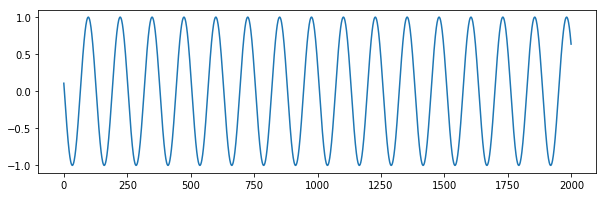

In [10]:
np.random.seed(2)

T = 20
L = 2000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / T).astype('float64')

fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(data[0, :])

<h3>Start CAS Session, Define Pandas Series, Load and Process Time Series Table, Create Train, Validate, and Test Partitions for Time Series Data</h3>


This step begins by connecting to a SAS CAS session. Create a variable `conn` to contain the CAS host and port connection information.

Next, create the a pandas series from the first row of the `data` array (the sinusoid wave showing above), and name it as `sine`. Use the `from_pandas()` function from the DLPy`TimeseriesTable` module to load the pandas series into a CAS table named `sine_tbl`. Use `timeseries_formatting()` to format the CAS table `sine_tbl` where the timeseries values are stored in the column `sine` and `timeid` values stored in the column `index`. 

Use DLPy `timeseries_accumlation()` to accumulate the formatted time series table `sine_tbl` using `OBS` (observation) as the accumulation interval. Now use DLPy `prepare_subsequences()` to create time series subsequences for the `sine` data with sliding windows, whose sizes are 100(specified as `seq_len`).

After dividing into subsequences, use DLPy `timeseries_partition()` to split the time series data into train, validate, and test partitions. Create variables named `validation_start` and `testing_start` to contain the respective `index` values of 1550 and 1750. The training data partition is defined by using `index` values of 0-1549 from `sine_tbl` as training data, `index` values from 1550 to 1749 from `sine_tbl` as validation data, and `index` values from 1750 to 2000 as test data.

In [11]:
conn = CAS(hostname, portnumber)

one_sine = pd.Series(data[0,:], name='sine')

# Load table from pandas series
sine_tbl = dlpy.TimeseriesTable.from_pandas(conn, one_sine)

# Formatting timeseries
sine_tbl.timeseries_formatting(timeid='index',timeseries='sine')

# Accumulate timeseries
sine_tbl.timeseries_accumlation(acc_interval='OBS')

# Make timeseries into subsequences
sine_tbl.prepare_subsequences(seq_len=100, target='sine')

# Split time series into train and test
validation_start = 1550
testing_start = 1750

train_tbl, valid_tbl, test_tbl = sine_tbl.timeseries_partition(validation_start=validation_start, testing_start=testing_start)

NOTE: Timeseries formatting is completed.
NOTE: Added action set 'timeData'.
NOTE: Timeseries are accumulated to the frequency of OBS
NOTE: timeseries subsequences are prepared with subsequence length = 100
NOTE: Training set has 1450 observations
NOTE: Validation set has 200 observations
NOTE: Testing set has 250 observations


<h3>Create Model and Define LSTM-RNN Network Architecture</h3>

Use DLPy `Sequential()` to create `model1` with `model_table` saved as `lstm_rnn`. Next, use `add()` to specify an input layer, followed by a pair of recurrent `LSTM` RNN layers with 15 neurons. Finally, use `add()` to specify the network output layer usng the `IDENTITY` activation function.

Then, use `print_summary()` to generate a table that displays a table overviewing the model architecture.

In [12]:
model1 = Sequential(conn, model_table='lstm_rnn')

model1.add(InputLayer(std='STD'))
model1.add(Recurrent(rnn_type='LSTM', output_type='samelength', n=15, reversed_=False))
model1.add(Recurrent(rnn_type='LSTM', output_type='encoding',  n=15, reversed_=False))
model1.add(OutputLayer(act='IDENTITY'))

model1.print_summary()

NOTE: Input layer added.
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


,Layer,Type,Activation,Output Size
0,Input1,input,None,0
1,Rec.1,recurrent,Auto,15
2,Rec.2,recurrent,Auto,15
3,Output1,output,Identity,None


<h3>Specify LSTM-RNN Network Optimization Algorithm and Sequence Information</h3>

Now use DLPy `Optimizer()` to specify the model optimization algorithm and optimization parameters. Use the `AdamSolver()` algorithm, with a mini-batch size of 32, a random seed value of 1234, and a maximum of 100 epochs. Save the `Optimizer()` specifications to `optimizer`.

Next set the essential sequence modeling information using the attributes of the `train_tbl` where we composed those attributes while formatting the time series data.

In [14]:
optimizer = Optimizer(algorithm=AdamSolver(), mini_batch_size=32, seed=1234, max_epochs=100)

# The attribute sequence_opt of train_tbl contains all the essential sequence modeling information
# It includes: input_length, target_length, token_size
seq_spec  = Sequence(**train_tbl.sequence_opt)

<h3>Train the LSTM-RNN Model1 Network using Model.fit()</h3>

After defining the network architecture and parameters, use the `fit()` function to train the LSTM-RNN `model1` network. Use the training data saved as `train_tbl` during partitioning.

The preceding code populated variable `optimizer` with the parameter settings (algorithm=AdamSolver(), mini_batch_size=32, seed=1234, max_epochs=100). The `optimizer=optimizer` statement in the following code configures the `optimizer=` parameter settings for `model1`, using the values stored in the `optimizer` variable.

The `valid_table=valid_tbl` statement sets the validation table parameter `valid_table` to a table named `valid_table`. The table `valid_tbl` was created earlier in this example, when the data was partitioned. 



In [15]:
# The inputs_target attribute of train_tbl contains the information of inputs vectors and target value
result = model1.fit(train_tbl, optimizer=optimizer, sequence=seq_spec, valid_table=valid_tbl, **train_tbl.inputs_target)

NOTE: Training from scratch.


Now use `plot_training_history()` to create a matplotlib plot of the LSTM-RNN `model1` loss and fit error values across model training epochs:

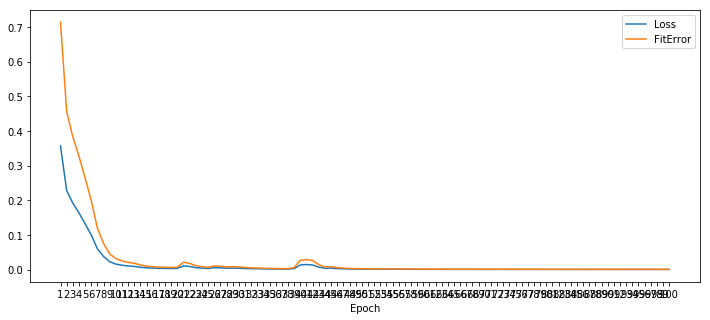

In [16]:
model1.plot_training_history()

The resulting plot shows that the model loss shows little variation between the training and validation data. This is a good sign that the model is not overfitted to the training data.

<h3>Train the LSTM-RNN Model1 Network using Model.train()</h3>

SAS DLPy allows you to train deep learning network models using either `model.fit()` or `model.train()`. Both functions serve the same purpose, but `model.train()` contains additional input options that provide user flexibility.  

The example code that follows uses the `model_train()` function to train `model1` using the train data in `train_tbl`. The `model_weights` option stores the trained model weights in a CAS table named `rnn_weights`. Save the trained model as `result`. If there is existing data in `result`, overwrite the old data. Use the same variable mappings for `valid_table`, `optimizer`, and `sequence` that were used to initally train the model.

Use `plot()` to display a 12 x 5 graph for all of the `FitError` and `ValidError` parameter values that were generated during the model optimization iteration history and saved in `result`. 

Use `plt.gca()` to get the current plotting Axes object. Use `get_xaxis()` and `get_yaxis()` with `set_tick_params()` to specify the axis tick and label appearance parameters. Use `legend()` to create a legend label for `Fit Error` and `Valid Error` in the upper right corner of the plot. Finally, use `set_xlabel()` and `set_ylabel()` to specify x and y axis label text (`Iterations` and `Loss`).


Text(0,0.5,'Loss')

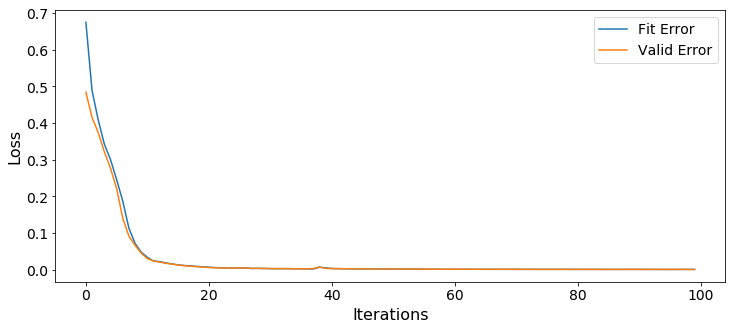

In [19]:
result = model1.train(train_tbl, model='lstm_rnn', model_weights=conn.CASTable('rnn_weights', replace=True),
           valid_table=valid_tbl, optimizer=optimizer, sequence=seq_spec, **train_tbl.inputs_target)

result.OptIterHistory[['FitError', 'ValidError']][0:].plot(figsize=(12,5))
ax = plt.gca()
ax.get_xaxis().set_tick_params(labelsize=14)
ax.get_yaxis().set_tick_params(labelsize=14)
ax.legend(['Fit Error', 'Valid Error'], loc='upper right', prop={'size': 14})
ax.set_xlabel('Iterations',fontsize=16)
ax.set_ylabel('Loss',fontsize=16)

Tne resulting plot shows stable model performance with little variation between the train and validation data sets. The model fit appears to be good. 



<h3>Use the LSTM-RNN Network Model to Score the Test Data (one-step-ahead forecast)</h3>

Now use `model1` with the saved weight file `rnn_weights` to score the test data, and write the output to a CAS table named `predicted`. Use `copy_vars` to copy the `index` and `sine` columns from the `test_tbl` to the CAS table `predicted`. **(Note this is one-step-ahead forecast when we use `model1.score` function. For detailed explaination of the differences between one-step-ahead and multi-step-ahead forecasting, please see the example "Multisteps_vs_Onestep_ahead_Forecasting.ipynb".)**

Create table `localtest` with the structure of the CAS table `predicted`, and use `fetch()` to populate `localtest` with the data in `predicted`. The parameters `to=` and `maxrows=` of the `fetch()` function are set to `localtest.shape[0]`, which is a value equal to the number of rows in the table. The `localtest` is a local copy of the CAS table `predicted`.

Next use matplotlib `subplots()` to create a 16 x 8 ouptput plot `ax` that will contain both the historical (training and validation data)  and the forecasted (predicted) values (from scoring the `model1` test data). Plot a blue line to display the historical time series sine curve data and a dotted red line to represent the forecasted sine curve data.

Use `plot()` to graph the blue sine curve for the historical data. Use the `one_sine` table `index` values as `x` coordinate data. Use the `iloc` indexer to select the row data for each row of the `one_sine` table as the `y` coordinate data. In this case, the row data for each `index` value is the `sine` value associated with the coordinate location. 

The range of `index` values used to plot the blue line includes both training and validation data observations. Recall that in the input data table `one_sine`, observations 0-1549 are partitioned for training, observations 1550 to 1749 for validation, and observations 1750 to 2000 for test. Therefore the index expression `[:testing_start]` selects observations 1 through 1749 for both `x` and `y` plot coordinates. 

Next, use `plot()` and the `localtest` copy of the `model1` output `predicted` table to graph the dotted red line of forecasted time series values. The range of predicted values corresponds with the test data partition of `one_sine`, which is observations 1750-2000. The `x` coordinate values are defined by the `index` values for each observation (from 1750 to 2000). The `y` coordinate values are found in the predicted value column `_DL_PRED_` of the test data `localtest`.

Use `get_xaxis()` and `get_yaxis()` with `set_tick_params()` to specify the axis tick and label appearance parameters. 
Use `set_ylim()` to specify the y-axis range from `-1.5` to `1.5`. 

Use `legend()` to create legend labels for `History Value` and `Forecasted Value` in the upper right corner of the plot. Finally, use `set_xlabel()` and `set_ylabel()` to specify x and y axis label names (`Iterations` and `Loss`).


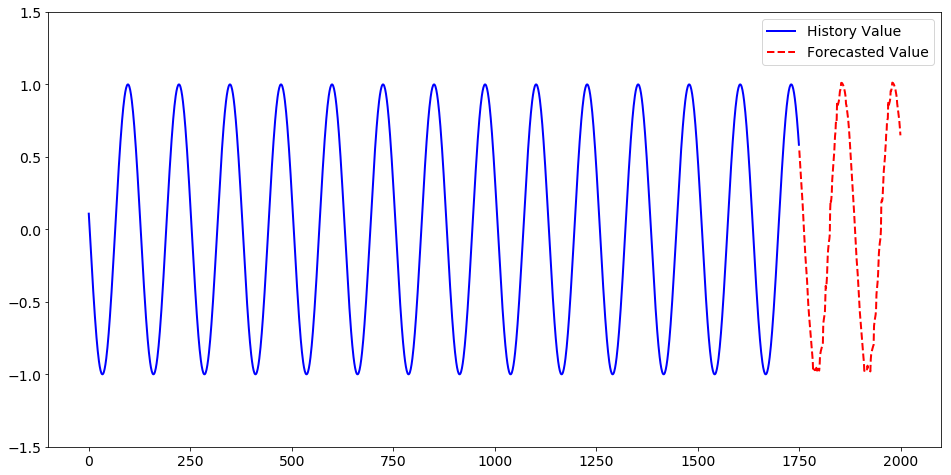

In [21]:
r2 = model1.score(test_tbl, model = 'lstm_rnn', init_weights = 'rnn_weights', 
                  copy_vars=['index', 'sine'], casout=dict(name='predicted', replace=True))

localtest = conn.CASTable('predicted')
localtest = localtest.fetch(to=localtest.shape[0], maxrows = localtest.shape[0])['Fetch']


fig, ax = plt.subplots(1,1,figsize=(16,8))
ax.plot(one_sine.index[:testing_start], one_sine.iloc[:testing_start],  linewidth=2, color='blue')
ax.plot('index','_DL_Pred_', data = localtest, linestyle='--', color='red',  linewidth=2)
ax.get_xaxis().set_tick_params(direction='out', labelsize=14)
ax.get_yaxis().set_tick_params(labelsize=14)
ax.set_ylim([-1.5, 1.5])
ax.legend(['History Value', 'Forecasted Value'], loc='upper right', prop={'size': 14})